# The z-transform

The infinite impulse response filters that we've encountered in the previous chapter can be thought of as a generalization of convolutional, finite impulse response filters.
We first saw convolution in the time domain, where it has the interpretation of mixing delayed and gained copies of the input signal.
We then saw how in the frequency domain, this is equivalent to taking the element-wise product of the Fourier transforms of the signal and filter coefficients.
This observation provided the tools we need to understand the effect that any given convolutional filter will have when applied to an input signal.

This leads us to the central question of this chapter: **can we analyze IIR filters in the frequency domain as well?**

It turns out that the answer is **yes**, but *not with the discrete Fourier transform*.
We'll need a new tool, which is known as the **z-transform**!

In [1]:
%run ../setup.ipynb

## Why can't we use the DFT?

It's worth taking a step back, and reconstructing the chain of reasoning that led us to the discrete Fourier transform and the convolution theorem.

The DFT is defined in terms of **analysis frequencies**: those which complete an integral number of cycles over a fixed duration of time ($N$ samples).
The DFT is then constructed by comparing the similarity (sum-product) of the input signal $\blue{x[n]}$ to a collection of complex exponentials at the chosen analysis frequencies.
Remember: the DFT always has the same number of analysis frequencies $N$ as input samples.

The convolution theorem provides a way to understand convolution $\purple{y} = \red{h} * \blue{x}$ in terms of the per-frequency DFT products $\darkblue{X[m]} \cdot \red{H[m]}$.
For this to work, the two DFT sequences $\darkblue{X[m]}$ and $\red{H[m]}$ must have the same (finite) length $N$.
This is not a significant barrier: both $\blue{x}$ and $\red{h}$ must be finite length for the DFT to be defined in the first place, and we can always zero-pad the shorter signal to match the longer signal.

However, when we have an IIR filter, this does not work.
Even for relatively simple filters, like the exponential moving average

```{math}
\purple{y[n]} = \red{1/2} \cdot \blue{x[n]} + \cyan{1/2} \cdot \purple{y[n-1]},
```

the impulse response can be infinite in length: there is no finite $N$ for which all $\purple{y[n > N]} = 0$.
As a result, there is no finite $N$ from which we can determine the analysis frequencies, which we would need to construct the DFT!


## Defining the z-transform

The limitations of the DFT ultimately all come from the dependence on knowing the length of the signal $N$.
Therefore, to remove these limitations, we will need to modify the DFT definition everywhere the length $N$ appears.

Recall the definition of the DFT for frequency index $m$:

```{math}
\darkblue{X[m]} = \sum_{n=0}^{N-1} \blue{x[n]} \cdot \purple{e^{-\mathrm{j}\cdot 2\pi \cdot \frac{m}{N} \cdot n}}.
```

The length $\blue{N}$ appears in two places here: once in the limit of the summation ($\blue{N-1}$), and once in the complex exponential.

The first step we will take is to rewrite the DFT definition by using the exponent multiplication rule 

```{math}
e^{a\cdot b} = {(e^a)}^b.
```

<Figure size 216x216 with 1 Axes>

<Figure size 216x216 with 1 Axes>

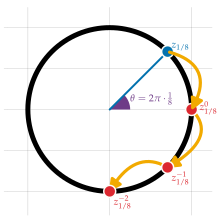

In [8]:
fig, ax = plt.subplots(figsize=(3, 3))

N = 8
m = 1
angle = 2 * np.pi * m / N
x, y = np.cos(angle), np.sin(angle)

circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=5, fill=False)

a2 = patches.FancyArrowPatch((x, y), (1, 0),
                                 connectionstyle="angle3,angleA=-15,angleB=60", 
                                 arrowstyle='simple, head_width=10, head_length=10', 
                                 color=colors[2], linewidth=3, zorder=10)
ax.add_patch(a2)

a3 = patches.FancyArrowPatch((1, 0),(x, -y), 
                                 connectionstyle="angle3,angleA=-45,angleB=-150", 
                                 arrowstyle='simple, head_width=10, head_length=10', 
                                 color=colors[2], linewidth=3, zorder=3)
ax.add_patch(a3)

a4 = patches.FancyArrowPatch((x, -y),(np.cos(-2*angle), np.sin(-2*angle)), 
                                 connectionstyle="angle3,angleA=150,angleB=60", 
                                 arrowstyle='simple, head_width=10, head_length=10', 
                                 color=colors[2], linewidth=3, zorder=3)
ax.add_patch(a4)

ax.plot([x, 0], [y, 0], marker='o', markersize=12, markevery=2)
arc = patches.Wedge((0, 0), 0.25, theta1=0, theta2=angle * 180 / np.pi, facecolor=colors[4])
ax.text(0.25, 0.1, r'$\theta = 2 \pi \cdot \frac{1}{8}$',  color=colors[4])
ax.text(x + 0.05, y + 0.05, r'$z_{1/8}$', color=colors[0])
ax.text(1 + 0.1, 0 + 0.1, r'$z_{1/8}^{0}$', color=colors[1], va='top')
ax.text(x + 0.05, -y - 0.05, r'$z_{1/8}^{-1}$', color=colors[1], va='top')
ax.text(np.cos(2*angle) + 0.05, np.sin(-2*angle) - 0.05, r'$z_{1/8}^{-2}$', color=colors[1], va='top')
#ax.plot([x, 0], [y, 0], c=colors[0], marker='o', s=100, zorder=4)
#ax.scatter([1, x, np.cos(2*angle)], [0, -y, np.sin(-2*angle)], c=colors[1], marker='o', s=100, zorder=4)
ax.plot([1, x, np.cos(2*angle)], [0, -y, np.sin(-2*angle)], c=colors[1], marker='o', linestyle='', markersize=12, zorder=4)
ax.add_patch(circ)
ax.add_patch(arc)

ax.set(xlim=[-1.25, 1.25], ylim=[-1.25, 1.25], 
        xticklabels=[], yticklabels=[]);
ax.set_aspect('equal')
glue('zmplot', fig, display=False)

````{margin}
```{glue:figure} zmplot
:alt: Illustration of a complex point being raised to successive negative powers traveling around the unit circle

When the complex number $z_{1/8} = \exp(\mathrm{j}\cdot 2\pi \cdot 1/8)$ is raised to successive powers $z_{1/8}^{-n}$ for $n=0, 1, 2, \dots$, the resulting effect is to move the point clockwise around the unit circle by steps of $2\pi\cdot 1/8$ radians.
This general pattern holds for any $z_{m/N}$ with integers $m$ and $N$, which provide the basis for the discrete Fourier transform.
```
````

Specifically, we can rewrite the complex exponential by factoring out $-n$ as a power:

```{math}
\purple{e^{-\mathrm{j}\cdot 2\pi \cdot \frac{m}{N} \cdot n}} = \left(\purple{e^{2\pi \cdot \mathrm{j} \cdot \frac{m }{ N}}}\right)^{-n}.
```

We can now interpret this as a sequence (parametrized by sample index $n$) generated by a complex number $z_{m/N}$ on the unit circle at angle $\theta = 2\pi \cdot m / N$, or

```{math}
:label: zm

\purple{z_{m/N}} = \purple{e^{2\pi \cdot \mathrm{j} \cdot \frac{m }{ N}}}.
```

The ratio $m/N$ can thus be interpreted as the fraction of the circle we travel in each step $n$ of the sequence: when $m$ is a small integer, the steps are small, so it will take more steps to traverse the entire circle.
That is, small $m$ corresponds to low frequency, as we should expect.
The length $N$ determines the smallest non-zero step ($1/N$), and as $N$ increases, we can take smaller steps.

If we take {eq}`zm`, we can rewrite the DFT calculation as a polynomial in $z_{m/N}$:

```{math}
\darkblue{X[m]} = \sum_{n=0}^{N-1} \blue{x[n]} \cdot  \purple{(z_{m/N})}^{-n}.
```

If we now define $x[n < 0] = x[n \geq N] = 0$, so that the input signal is assumed to be silent outside the observed set of samples, we can relax the finite summation for $n=0 \dots N-1$ to an infinite summation:

```{math}
\darkblue{X[m]} = \sum_{n=0}^\infty \blue{x[n]} \cdot  \purple{(z_{m/N})}^{-n}.
```

This form is still equivalent to the DFT, but under the assumption of silence after $\blue{N}$ samples, rather than infinite repetition.

The final step is to replace $\purple{z_{m/N}}$ (which correspond to our analysis frequencies for $m=0,1,2,\dots,N-1$) by *any* complex number $z$.
In doing so, we have completely eliminated the dependence on the signal duration $\blue{N}$.
The resulting transformation of $\blue{x[n]}$ is no longer a sequence of $\blue{N}$ complex numbers $\darkblue{X[0], X[1], \dots, X[N-1]}$, but instead defines a continuous function $\darkblue{X(z)}$ which can be evaluated for *any* complex number $\purple{z}$, hence the name: **z-transform**.

````{prf:definition} The z-transform

Given a sequence $\blue{x[n]}$ (of possibly infinite length), the z-transform is a function $\darkblue{X(z)}$ over complex numbers $\purple{z}$ defined as follows:

```{math}
:label: ztransform

\darkblue{X(z)} = \sum_{n=0}^\infty \blue{x[n]} \cdot  \purple{z}^{-n}.
```
````

## Relating the z-transform to the DFT

The first thing to be absolutely clear about is that the z-transform does not "replace" the DFT exactly.
In particular, we don't typically use the z-transform to analyze a signal $\blue{x[n]}$ directly.
As we'll see shortly, the z-transform is more useful for analyzing filters, and this works essentially by comparing the z-transforms of the input $\darkblue{X(z)}$ and the output $\magenta{Y(z)}$.

Unlike the DFT, the z-transform does not produce a finite sequence of coefficients.
Instead, it produces a *function* that can be evaluated for any complex number $\purple{z}$.
This function $\darkblue{X(z)}$ --- note the use of parentheses $(z)$ instead of square brackets $[n]$ --- is not really an object you would use directly, and it is primarily a conceptual device that we use for analysis.
For this reason, you are unlikely to encounter software implementations that compute {eq}`ztransform` for you.

However, the DFT can be recovered from the z-transform by evaluating $\darkblue{X(z)}$ at carefully chosen points $\purple{z}$.
Specifically, the DFT coefficients $\darkblue{X[m]}$ can be extracted from the z-transform $\darkblue{X(z)}$ as follows:

```{math}

\darkblue{X[m]} = \darkblue{X}\left(\purple{e^{2\pi\cdot \mathrm{j} \cdot m / N}} \right).
```

## Aside: continuous frequency and the DTFT

Another special case of the z-transform is known as the *discrete-time Fourier transform* (DTFT).
The DTFT is similar to our conventional DFT, except that instead of using $\blue{N}$ analysis frequencies $0, f_s/N, 2\cdot f_s/N, \cdots$, it is defined for **any** frequency $f$.
The DTFT gets its name from the fact that it is continuous in frequency, but still discrete in time.

The DTFT for any frequency $f$ is obtained by evaluating the z-transform at a point on the unit circle with angle $2\pi \cdot f / f_s$:

```{math}
\text{DTFT}(x)(f) = \darkblue{X}\left( \purple{e^{\mathrm{j}\cdot 2\pi \cdot f / f_s}} \right).
```

For our purposes, the DTFT is primarily useful as a way to use the z-transform for arbitrary frequencies, not just analysis frequencies.
Note that the DTFT also makes the connection between frequency and angle precise: a frequency $\purple{f}$ with sampling rate $f_s$ is associated with a complex number of unit magnitude and angle $2\pi \cdot \purple{f} / f_s$.
For example:
- frequency $f=0$ is associated with angle 0;
- aliasing frequencies map to the same angle, since 
```{math}
2\pi \cdot \frac{\purple{f} + \red{k\cdot f_s}}{f_s} = 2\pi \cdot \frac{\purple{f}}{f_s} + 2\pi \cdot \red{k} \equiv 2\pi \cdot \frac{\purple{f}}{f_s},
```
- and the Nyquist frequency $\purple{f} = f_s / 2$ is associated with angle $2\pi \cdot (f_s/2) / f_s = \pi \equiv -\pi$.

This generalizes the DFT's analysis frequencies, in that using $\purple{f = m \cdot f_s / N}$ exactly recovers the points $\purple{z_{m/N}}$ defined above in {eq}`zm`.
More generally, the range of frequencies $0 \leq f \leq f_s$ are mapped continuously to the range of angles $0 \leq \theta \leq 2\pi$.
This will become useful later on, when we use the z-transform to understand frequency response of feedback filters.

<Figure size 216x216 with 1 Axes>

<Figure size 216x216 with 1 Axes>

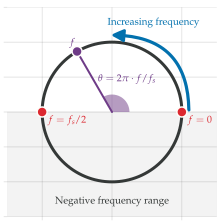

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))

angle = 2 * np.pi / 3

arc = patches.Wedge((0, 0), 1, theta1=0, theta2=360, edgecolor=colors[3], facecolor=None, fill=False, linewidth=3)
ax.add_patch(arc)

ax.plot([1, -1], [0, 0], c=colors[1], marker='o', markersize=10, zorder=4, linestyle='')

ax.plot([np.cos(angle), 0], [np.sin(angle), 0], c=colors[4], marker='o', markersize=10, markevery=2, zorder=4)
arc = patches.Wedge((0, 0), 0.25, theta1=0, theta2=angle * 180 / np.pi, facecolor=colors[4], alpha=0.5)
ax.add_patch(arc)
ax.text(-0.2, 0.4, r'$\theta = 2\pi \cdot f / f_s$', color=colors[4], va='bottom', ha='left')

arc = patches.FancyArrowPatch((1.1, 0),(0, 1.1), 
                                 connectionstyle="angle3,angleA=90,angleB=0", 
                                 arrowstyle='simple, head_width=10, head_length=10', 
                                 color=colors[0], linewidth=3, zorder=3)
ax.add_patch(arc)
ax.axhspan(-1.5, 0, alpha=0.05, color='k', zorder=-1)
ax.text(1.25, 1.35, 'Increasing frequency', color=colors[0], va='top', ha='right')
ax.text(1.1, -0.05, r'$f=0$', color=colors[1], va='top', ha='left')
ax.text(-0.9, -0.05, r'$f=f_s/2$', color=colors[1], va='top', ha='left')
ax.text(np.cos(angle) -0.05, np.sin(angle) + 0.05, r'$f$', color=colors[4], va='bottom', ha='right')
ax.text(0, -1.35, 'Negative frequency range', color=colors[3], va='bottom', ha='center')

ax.set(xlim=[-1.5, 1.5], ylim=[-1.5, 1.5], 
        xticklabels=[], yticklabels=[]);
ax.set_aspect('equal')
glue('frequencies', fig, display=False)

```{glue:figure} frequencies
:alt: Illustration of frequency mapping onto angle

The z-transform (and discrete-time Fourier transform) associates each continuous frequency $\purple{f}$ with a specific angle $\purple{\theta = 2\pi \cdot f / f_s}$.
Angles in the upper half of the complex plane correspond to positive frequencies between $\red{0}$ and $\red{f_s/2}$ (the Nyquist frequency).
Angles in the lower half correspond to negative frequencies between $\red{0}$ and $\red{-f_s/2} \equiv \red{f_s/2}$.
```

## Summary

We've now introduced the fundamental tool that we'll need to analyze IIR filters.
At this point, you might be wondering how or why this idea is useful.
On the one hand, we've generalized the DFT in a way that no longer depends on the signal length.
On the other hand, the resulting transformation doesn't actually produce a finite representation of the signal, and is not something that we could explicitly compute anyway, since it encodes a function $\darkblue{X(z)}$ on the entire complex plane $\mathbb{C}$.

As we will see in the coming sections, the power of the z-transform is that it allows us to reason algebraically about signals and filters --- even infinitely long signals --- in terms of polynomials (e.g., $z^2 - z + 1$).
In the next section, we'll establish the properties of the z-transform that make this work.